# Experimental validation of recomendation engine
In this experiment we will see the reccomendations perform in relation to recommendations made by using the simulator as an "oracle".

In [1]:
%cd ..
%mkdir output
%pwd

/home/dampen/projects/datx02-05


'/home/dampen/projects/datx02-05'

In [2]:
import math
import os
import sys
import copy
project_dir, _ = os.path.split(sys.path[0])
sys.path.insert(0, project_dir)
sys.path.insert(0, os.path.join(project_dir, "models"))
sys.path.insert(0, os.path.join(project_dir, "models", "MLmodels"))
sys.path.insert(0, os.path.join(project_dir, "models", "MLmodels", "ElasticNets"))

import pandas as pd
import sklearn as sk
import seaborn as sn
from simulator.generator import generate_individuals, save_individuals
from simulator.gym import load_training, train
from simulator.__init__ import train_and_save
from data_parser import ttrdata_from_csv_population_4_weeks
from recengine import RecommendationEngine

POPULATION_SIZE = 5*100

## Creating the dataset
For our experiment we need a dataset. We will start by generating a population of individuals:

In [3]:
testing_population = generate_individuals(POPULATION_SIZE, 100, 5)
testing_population[0].bench_press_movement.get_current_performance()

98.0

We need to get a set of training programs for these individuals to run before attempting to give them recommendations:

In [4]:
def remove_fluff(path):
    return os.path.split(path)[1].split(".")[0]


programs_path = os.path.realpath("simulator/training_programs")
training_programs = [os.path.join(programs_path, f) for f in os.listdir(programs_path) 
                     if os.path.isfile(os.path.join(programs_path, f))]

training_program_labels = [remove_fluff(program) for program in training_programs]
display(training_programs)
display(training_program_labels)

['/home/dampen/projects/datx02-05/simulator/training_programs/6w_bp_fiesta.csv',
 '/home/dampen/projects/datx02-05/simulator/training_programs/carls_power_program_BP.csv',
 '/home/dampen/projects/datx02-05/simulator/training_programs/kikuchi.csv',
 '/home/dampen/projects/datx02-05/simulator/training_programs/ogasawara_LL.csv',
 '/home/dampen/projects/datx02-05/simulator/training_programs/ogasawara_HL.csv']

['6w_bp_fiesta',
 'carls_power_program_BP',
 'kikuchi',
 'ogasawara_LL',
 'ogasawara_HL']

First of all the individuals will have to perform a training program prior to receiving a recommendation. We will divide the collection into different sets which all do different training protocols. We will distribute the individuals evenly between the training programs:

In [5]:
testing_groups = []

cohort_size = math.ceil(POPULATION_SIZE / len(training_programs))
for index, program in enumerate(training_programs):
    testing_groups.append(testing_population[index*cohort_size:(index+1)*cohort_size])
testing_groups

[[<simulator.individual.Individual at 0x7ff3c8f725b0>,

Now the testing population will need to perform the prerequisite training:

In [6]:
last_timestampt = None

for index, group in enumerate(testing_groups):
    
    # let the individuals in a cohort perform the presribed training
    last_timestamp = train_and_save(group, "./output/" + str(index) + ".csv", training_programs[index])
    
    # let us also save the group
    save_individuals(group, "./output/" + str(index) + "_pop.csv", last_timestamp)
        

display(pd.read_csv("./output/0.csv", sep="|"))
display(pd.read_csv("./output/0_pop.csv", sep="|"))

,ID,Exercise,Weight,Reps,Timestamp,Performance
0,0,1,49.0,5,2020-05-12 16:00:00,98.000000
1,0,1,68.6,3,2020-05-12 16:03:00,98.000000
2,0,1,68.6,3,2020-05-12 16:06:00,98.000000
3,0,1,68.6,3,2020-05-12 16:09:00,98.000000
4,0,1,73.5,3,2020-05-12 16:12:00,98.000000
...,...,...,...,...,...,...
22195,99,1,75.2,2,2020-06-20 16:12:00,102.335832
22196,99,1,75.2,2,2020-06-20 16:15:00,102.335832
22197,99,1,75.2,2,2020-06-20 16:18:00,102.335832
22198,99,1,75.2,2,2020-06-20 16:21:00,102.335832


,ID,Name,bench_press_fitness,bench_press_fatigue,bench_press_basic_performance,bench_press_fitness_gain,bench_press_fatigue_gain,bench_press_fitness_decay,bench_press_fatigue_decay,Timestamp
0,0,Christopher Mosher,5.398413,2.391711,96.684369,1.366698,3.634900,6,2,2020-06-20 16:24:00
1,1,Brenda Layfield,12.367841,10.957367,87.246661,1.380051,1.900237,15,13,2020-06-20 16:24:00
2,2,Brittany Coleman,13.819784,5.428228,141.209894,3.874994,1.536724,27,9,2020-06-20 16:24:00
3,3,Bill Fisher,7.575636,1.560114,108.818561,1.975568,2.658536,10,1,2020-06-20 16:24:00
4,4,Robert Saunders,15.982585,3.836976,160.830859,3.618678,1.825649,33,6,2020-06-20 16:24:00
...,...,...,...,...,...,...,...,...,...,...
95,95,Robert Jones,13.482901,9.005795,121.887973,3.266161,2.570495,21,13,2020-06-20 16:24:00
96,96,Thomas Spangle,13.108604,7.515871,117.019670,4.097367,4.083505,21,11,2020-06-20 16:24:00
97,97,Janice Smith,18.109930,15.826648,116.390895,4.669622,3.802171,33,27,2020-06-20 16:24:00
98,98,Suzanne Jones,22.248414,13.853272,128.542780,3.894815,3.978171,48,23,2020-06-20 16:24:00


The training logs were saved in `simulator/output/`. We will now convert the training logs to inputs that are used for the models:

In [7]:
model_input = []

for index, group in enumerate(testing_groups):
    model_input.append(ttrdata_from_csv_population_4_weeks(os.path.join("./output", str(index) + ".csv")))
    
model_input[0]

,id,load_week1,max_week1,load_week2,max_week2,load_week3,max_week3,load_week4,max_week4
0,0,8423.10,100.400573,8423.10,100.512909,8423.10,100.531565,8423.10,100.534659
1,1,7821.45,88.392816,7821.45,88.277828,7821.45,88.317517,7821.45,88.385715
2,2,8251.20,129.956593,8251.20,134.957184,8251.20,137.948578,8251.20,139.717361
3,3,8423.10,109.883431,8423.10,110.265282,8423.10,110.387722,8423.10,110.427000
4,4,9454.50,146.565610,9454.50,152.911105,9454.50,156.982961,9454.50,159.604987
...,...,...,...,...,...,...,...,...,...
95,95,8680.95,115.521564,8680.95,118.417659,8680.95,120.233945,8680.95,121.319673
96,96,8079.30,109.251323,8079.30,113.214447,8079.30,115.605952,8079.30,116.943322
97,97,7907.40,107.000810,7907.40,110.642191,7907.40,113.469300,7907.40,115.617555
98,98,8337.15,109.797516,8337.15,116.628716,8337.15,122.849780,8337.15,128.133798


And now the testing population is ready for our experiment!

## Experiment
### Methodology
To compare the models with the ground truth we will need to first take the testing population and run them through each and every program, with the same starting state for each program. At this point we will be able to deduce which program gave the greatest increase in performance, and we will save the index of that program in a seperate list. This list will then serve as the "testing labels" and we will be able to see how often the recommendation engine gives the best training recommendation available.

In [8]:
# dataframe containing results of all test runs
testing_groups_results = [[] for _ in range(POPULATION_SIZE)]
i = 0

for group in testing_groups:
    
    for individual in group:
        
        # perform each training program
        for program_path in training_programs:
            
            # load given training program
            program = load_training(program_path, individual.bench_press_movement)
            
            # save a new individual instance so that we can compare to baseline
            trained_individual = copy.deepcopy(individual)
            
            # let copy of individual perform given training program
            train(program, trained_individual)
            
            # save results
            testing_groups_results[i].append(trained_individual.bench_press_movement.get_current_performance())
            
        i += 1
            
testing_groups_results = pd.DataFrame(testing_groups_results, columns=training_programs)
testing_groups_results

,/home/dampen/projects/datx02-05/simulator/training_programs/6w_bp_fiesta.csv,/home/dampen/projects/datx02-05/simulator/training_programs/carls_power_program_BP.csv,/home/dampen/projects/datx02-05/simulator/training_programs/kikuchi.csv,/home/dampen/projects/datx02-05/simulator/training_programs/ogasawara_LL.csv,/home/dampen/projects/datx02-05/simulator/training_programs/ogasawara_HL.csv
0,96.684691,87.255380,90.149589,92.523447,88.368208
1,87.378962,76.186872,83.372041,84.145176,83.618543
2,143.802702,208.797277,166.480354,166.241285,200.244838
3,108.841714,125.457165,112.417926,113.415621,123.058223
4,165.591355,238.533701,188.311783,190.250126,228.471925
...,...,...,...,...,...
495,152.164577,199.874751,154.600763,167.222960,193.977608
496,154.774838,204.109562,158.804189,170.602100,198.164303
497,100.447504,76.251771,89.853249,92.401013,89.144451
498,105.544945,124.058568,110.075997,110.873042,121.442810


Create labels representing best results:

In [9]:
y = pd.DataFrame(testing_groups_results.idxmax(axis=1))

y[0] = y[0].apply(remove_fluff)

y

,0
0,6w_bp_fiesta
1,6w_bp_fiesta
2,carls_power_program_BP
3,carls_power_program_BP
4,carls_power_program_BP
...,...
495,carls_power_program_BP
496,carls_power_program_BP
497,6w_bp_fiesta
498,carls_power_program_BP


We now have the ground truth labels!

### Training models
We need models to feed the recommendation engine. Here we will download those models from our release page:

In [10]:
%cd output

# download from release
!curl -L https://github.com/vifraa/datx02-05/releases/download/1.0/release1_0.tar.gz --output release.tar.gz
    
# extract
!tar xzf release.tar.gz

%cd release1_0/models

%cd ../../..
%mv output/release1_0/models recengine/models

/home/dampen/projects/datx02-05/output
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   630  100   630    0     0   2218      0 --:--:-- --:--:-- --:--:--  2218
100 20.3M  100 20.3M    0     0  7024k      0  0:00:02  0:00:02 --:--:-- 9878k
/home/dampen/projects/datx02-05/output/release1_0/models
/home/dampen/projects/datx02-05


### Getting the recommendation engines suggestions
Now that we have the ground truth and the models we will need to get the recommendation engines predictions for the best program:

In [11]:
rec = RecommendationEngine("models")

pred = []

recommendation = 0

for group in model_input:

    for _, ttr in group.iterrows():
        input_data = ttr.to_numpy().reshape(1, -1)[:,1:]
        recommendation = rec.recommend_training(input_data)[0]["model"].name
        pred.append(recommendation)
        

pred = pd.DataFrame(pred)
pred
#rec.models[4].name

,0
0,carls_power_program_BP
1,ogasawara_HL
2,carls_power_program_BP
3,carls_power_program_BP
4,carls_power_program_BP
...,...
495,carls_power_program_BP
496,carls_power_program_BP
497,carls_power_program_BP
498,carls_power_program_BP


And now all that remains is to evaluate how our experiment went!

# Metrics
Now we shall investigate how well our recommendation engine performs. We start by looking at the obvious, the accuracy:

In [13]:
pred

,0
0,carls_power_program_BP
1,ogasawara_HL
2,carls_power_program_BP
3,carls_power_program_BP
4,carls_power_program_BP
...,...
495,carls_power_program_BP
496,carls_power_program_BP
497,carls_power_program_BP
498,carls_power_program_BP


Let us also look at the confusion matrix of our recommendation engine:

In [21]:
from sklearn.metrics import accuracy_score

_cm = sk.metrics.confusion_matrix(y, pred, labels=training_program_labels)

cm = pd.DataFrame(
    _cm,
    index=training_program_labels,
    columns=training_program_labels
)

accuracy_score(y, pred)
#sn.heatmap(cm)

0.784

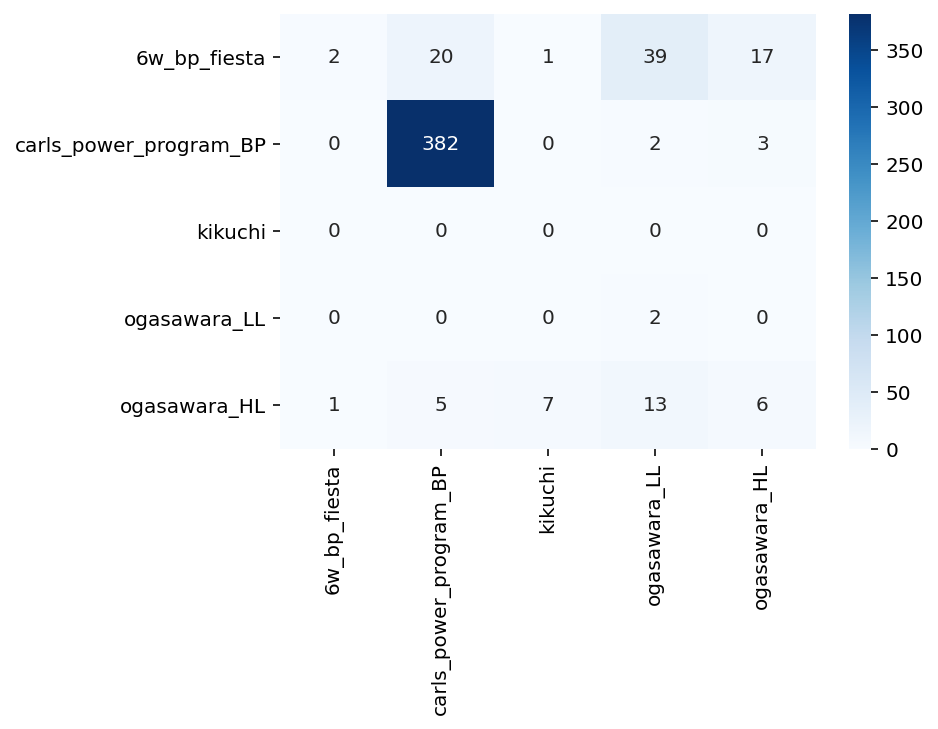

In [30]:
%config InlineBackend.figure_format = 'retina'
sn.heatmap(cm, cmap="Blues", annot=True, fmt='g')

# Cleaning
Run below cell to remove everything

In [15]:
#%rm -rf output
#%rm -rf recengine/models